In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Edited By     : Josh Nielsen
Edited On     : 28 November 2022

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

__editor__    = "Josh Nielsen"
__contact__   = "joshua.nielsen@und.edu"

In [69]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #pandas for reading in observations

In [70]:
### Define global variables ###
global delta_x
global delta_y
global x_not
global y_not
global map_scale
global phi_0
global range_factor
global Kd
global Re

In [71]:
### Create function for bilinear interpolation ###
def bilinear_interp(xob,yob,a):
    

    xind = (xob - x_not) / delta_x
    yind = (yob - y_not) / delta_y    
    sq_mat = np.matrix([[1, -1, -1, 1],[0, 0, 1, -1],[0, 1, 0, -1],[0, 0, 0, 1]])
    di = xind - np.floor(xind)
    dj = yind - np.floor(yind)
    xind = int(np.floor(xind))
    yind = int(np.floor(yind))
    a_mat = np.matrix([1, di, dj, di*dj]).T
    f_mat = np.matrix([a[yind, xind],
            a[yind,xind+1],
            a[yind+1, xind],
            a[yind+1, xind+1]])
    
    
    
    return f_mat * sq_mat * a_mat

In [72]:
### Create function for Barnes method background field ###
def barnes(x_points,y_points,f_not):
    weight = np.empty(len(x_points))
    for i in range(len(x_points)):
        k_distance = (x_points[i]**2 + y_points[i]**2)**0.5
        ind_weight = np.exp((-k_distance**2)/Kd)
        weight[i] = ind_weight
    return (np.nansum(weight*f_not)/np.sum(weight))

In [73]:
### Create function to obtain background for first pass of bilinear interpolation ###
def define_background_obs(roi):
    for i in range(len(hgts_500)):
        if x_obs[i] > np.amin(x_points) and \
            x_obs[i] < np.amax(x_points) and \
            y_obs[i] > np.amin(y_points) and \
            y_obs[i] < np.amax(y_points):
                background_obs[i] = bilinear_interp(x_obs[i],y_obs[i],background_ana[:,:])
        else:
            radians = ((x_obs[i]-x_points)**2 + (y_obs[i]-y_points)**2)**0.5
            if np.min(radians) > roi:
                background_obs[i] = np.nan
            else:
                rois_index = np.where(radians<=roi)
                rel_x_background = (x_obs[i]-x_points[rois_index]).flatten()
                rel_y_background = (y_obs[i]-y_points[rois_index]).flatten()
                heights = (background_ana[:,:][rois_index]).flatten()
                background_obs[i] = barnes(rel_x_background,rel_y_background,heights)

In [74]:
### Create function to find differences of analysis values at ob stations and then the analysis at ob stations ###
def ana_stations(N_val, ana_array):
    for i in range(len(hgts_500)):
        if x_obs[i] > np.amin(x_points) and \
            x_obs[i] < np.amax(x_points) and \
            y_obs[i] > np.amin(y_points) and \
            y_obs[i] < np.amax(y_points):
               ana_at_stations[i,N_val] = bilinear_interp(x_obs[i],y_obs[i],ana_array[:,:,N_val])
        else:
            radians = ((x_obs[i]-x_points)**2 + (y_obs[i]-y_points)**2)**0.5
            if np.min(radians) > Re:
                ana_at_stations[i,N_val] = np.nan
            else:
                rois_index = np.where(radians<=Re)
                rel_x_background = (x_obs[i]-x_points[rois_index]).flatten()
                rel_y_background = (y_obs[i]-y_points[rois_index]).flatten()
                heights = (ana_array[:,:,N_val][rois_index]).flatten()
                ana_at_stations[i,N_val] = barnes(rel_x_background,rel_y_background,heights)

In [89]:
### Create function to find backgournd error correlation between stations ###
def background_error_cor(N,x_points,y_points,ob_indexes):
    mat = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            diff_x = x_points[ob_indexes[j]]-x_points[ob_indexes[i]]
            diff_y = y_points[ob_indexes[j]]-y_points[ob_indexes[i]]
            s_rt = (diff_x**2 + diff_y**2)**0.5
            world = s_rt/map_scale
            unit_conversion_globe = (world)/(1000*1000*100)
            rho_scale = 0.95*np.exp((range_factor*(unit_conversion_globe**2)))
            if rho_scale == 0.95:
                mat[i,j] = 1
            else:
                mat[i,j] = rho_scale
    return np.linalg.inv(np.matrix(mat))

In [76]:
### Create function to find 1-D background error correlation for distance between grid and obs
def grid_background_error(N,x_points,y_points,pt_x,pt_y,ob_indexes):
    mat_2 = np.zeros([N])
    for i in range(N):
        diff_x = x_points[ob_indexes[i]]-pt_x
        diff_y = y_points[ob_indexes[i]]-pt_y
        s_rt = (diff_x**2 + diff_y**2)**0.5
        world = s_rt/map_scale
        unit_conversion_globe = (world)/(1000*1000*100)
        rho_scale = 0.95*np.exp((range_factor*(unit_conversion_globe**2)))
        mat_2[i] = rho_scale
    return np.matrix(mat_2)

In [77]:
### Read in observations ###
ds = pd.read_csv('RAOBs_201903131200.txt', sep=",", names = ['Station', 'Latitude', 'Longitude', 'Height', 'Wind_dir', 'Wind_spd'])
lons = ds['Longitude']
lats = ds['Latitude']
hgts_500 = ds['Height']

In [78]:
### Set constants ###
rho = 6371*1e5
phi_0 = 60*(np.pi/180)
lambda_0 = -115
map_scale = 1/(15e6)
x_not = 18.90
y_not = -6.30
delta_x = 1.27
delta_y = 1.27
x_n = 22
y_n = 28
range_factor = ((1+np.sin(40*(np.pi/180)))/(1+np.sin(phi_0)))* -1.24
Kd = 10.8844524
Re = 12.7775892

In [79]:
### convert obs lat/long to x,y ###
sigma = (1+np.sin(phi_0))/(1+np.sin((lats*(np.pi/180))))
r = rho*sigma*np.cos(lats*((np.pi/180)))*map_scale
x_obs = r*np.cos(((lons*(np.pi/180))-(lambda_0*(np.pi/180))))
y_obs = r*np.sin((lons*(np.pi/180))-lambda_0*(np.pi/180))

### Set up analysis map with a 22x28 rectangular grid of points ###
x_step = x_not + np.arange(22)*delta_x
y_step = y_not + np.arange(28)*delta_y
x_points, y_points = np.meshgrid(x_step, y_step)

### Convert x and y points to lat and lon for grid points ###
lon_grid = np.arctan(y_points/x_points)*(180/np.pi)+lambda_0
lat_grid = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_points/map_scale)**2+(y_points/map_scale)**2)/(rho*(1+np.sin(phi_0))))))

In [80]:
### Declare empty arrays for analysis values ###
ana_array = np.empty((y_n, x_n, 3))
background_obs = np.empty(len(hgts_500))
background_ana = np.empty((y_n, x_n))
ana_increments = np.empty((y_n, x_n, 3))
ana_at_stations = np.empty((len(hgts_500),3))
ana_diff = np.empty((len(hgts_500),3))

In [81]:
### Calculate 1st pass analysis background of analysis grid with observations and radius of influence
for i in range(len(x_points)):
    for j in range(len(x_points[0])):
        rel_x = x_points[i,j] - x_obs
        rel_y = y_points[i,j] - y_obs
        rel_rad = (rel_x**2 + rel_y**2)**0.5
        index_roi = np.where(rel_rad<Re)[0]
        x_k = rel_x[index_roi].values
        y_k = rel_y[index_roi].values
        f_not = hgts_500[index_roi].values
        background_ana[i,j] = barnes(x_k,y_k, f_not)

In [82]:
### Establish ob background field ###
define_background_obs(Re)

### Calculate ob increments ###
ob_increments = hgts_500-background_obs

In [108]:
### Set N values to find closest stations ###
n_values = [2,4,10]
for n in range(len(n_values)):
    N = n_values[n]
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            rel_x = x_points[i,j]-x_obs
            rel_y = y_points[i,j]-y_obs
            rel_rad = (rel_x**2 + rel_y**2)**0.5
            observations=np.argsort(rel_rad)[0:N]
            x_k = x_obs[observations]
            y_k = y_obs[observations]
            heights = ob_increments[observations]
            mat = background_error_cor(N, x_k, y_k,observations)
            rho_vec = grid_background_error(N,x_k,y_k,x_points[i,j],y_points[i,j],observations)
            weights = rho_vec*mat
            vals = np.empty([N])
            for k in range(N):
                vals[k] = weights[0,k]*ob_increments[observations[k]]
            ana_array[i,j,n] = background_ana[i,j] + (np.sum(vals))
    ana_stations(n, ana_array)

In [109]:
### Calculate analysis increments ###
ana_increments[:,:,0] = ana_array[:,:,0] - background_ana[:,:]
ana_increments[:,:,1] = ana_array[:,:,1] - background_ana[:,:]
ana_increments[:,:,2] = ana_array[:,:,2] - background_ana[:,:]

In [110]:
### Calculate analysis differences ###
ana_diff[:,0] = ana_at_stations[:,0] - hgts_500
ana_diff[:,1] = ana_at_stations[:,1] - hgts_500
ana_diff[:,2] = ana_at_stations[:,2] - hgts_500

In [111]:
### Calculate RMS values ###
rms_val_sum1 = (ana_at_stations[:,0] - hgts_500)**2
rms_val_sum1 = rms_val_sum1[~np.isnan(rms_val_sum1)]
rms_val_sum2 = (ana_at_stations[:,1] - hgts_500)**2
rms_val_sum2 = rms_val_sum2[~np.isnan(rms_val_sum2)]
rms_val_sum3 = (ana_at_stations[:,2] - hgts_500)**2
rms_val_sum3 = rms_val_sum3[~np.isnan(rms_val_sum3)]

rms_val1 = ((np.sum(rms_val_sum1))/len(rms_val_sum1))**0.5
print(rms_val1)
rms_val2 = ((np.sum(rms_val_sum2))/len(rms_val_sum2))**0.5
print(rms_val2)
rms_val3 = ((np.sum(rms_val_sum3))/len(rms_val_sum3))**0.5
print(rms_val3)

51.919230525837705
49.96061067453238
50.97242487632033


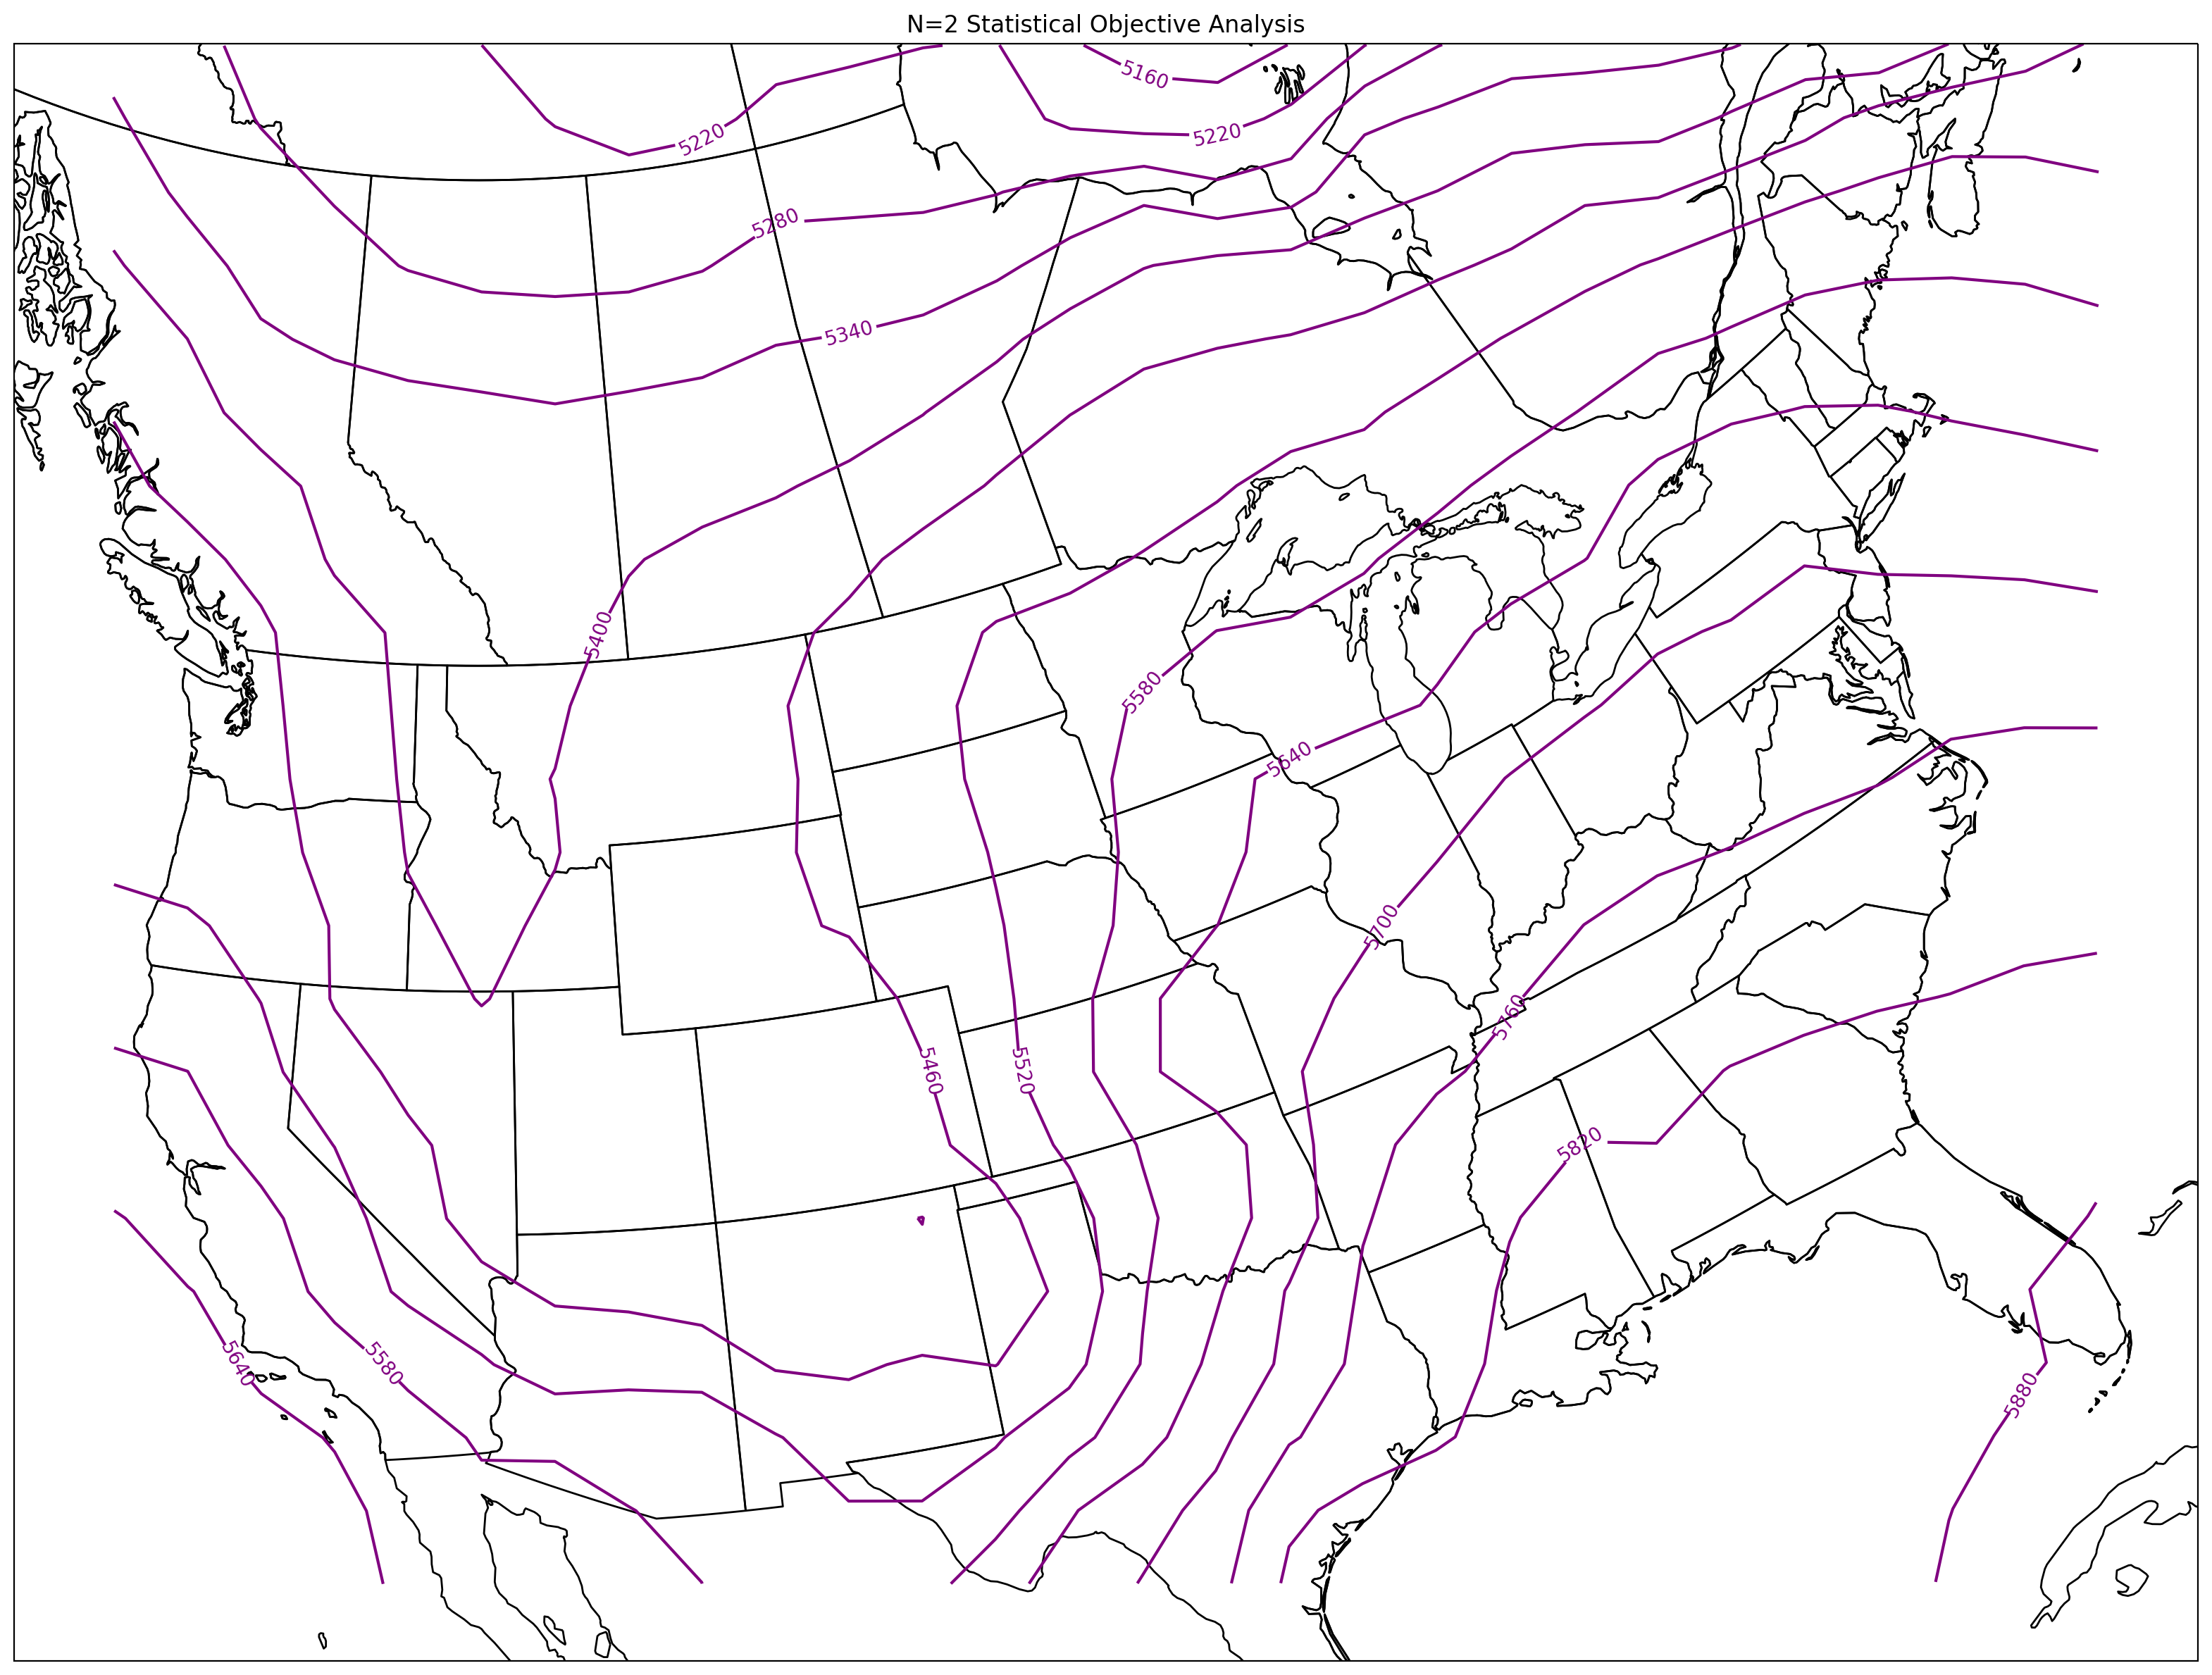

In [115]:
### Make plot for N=2 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_array[:,:,0], colors = 'purple', levels = np.arange(0,8000,60), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(0,8000,60))
plt.title('N=2 Statistical Objective Analysis')
plt.savefig('N=2 SOA')
plt.show()

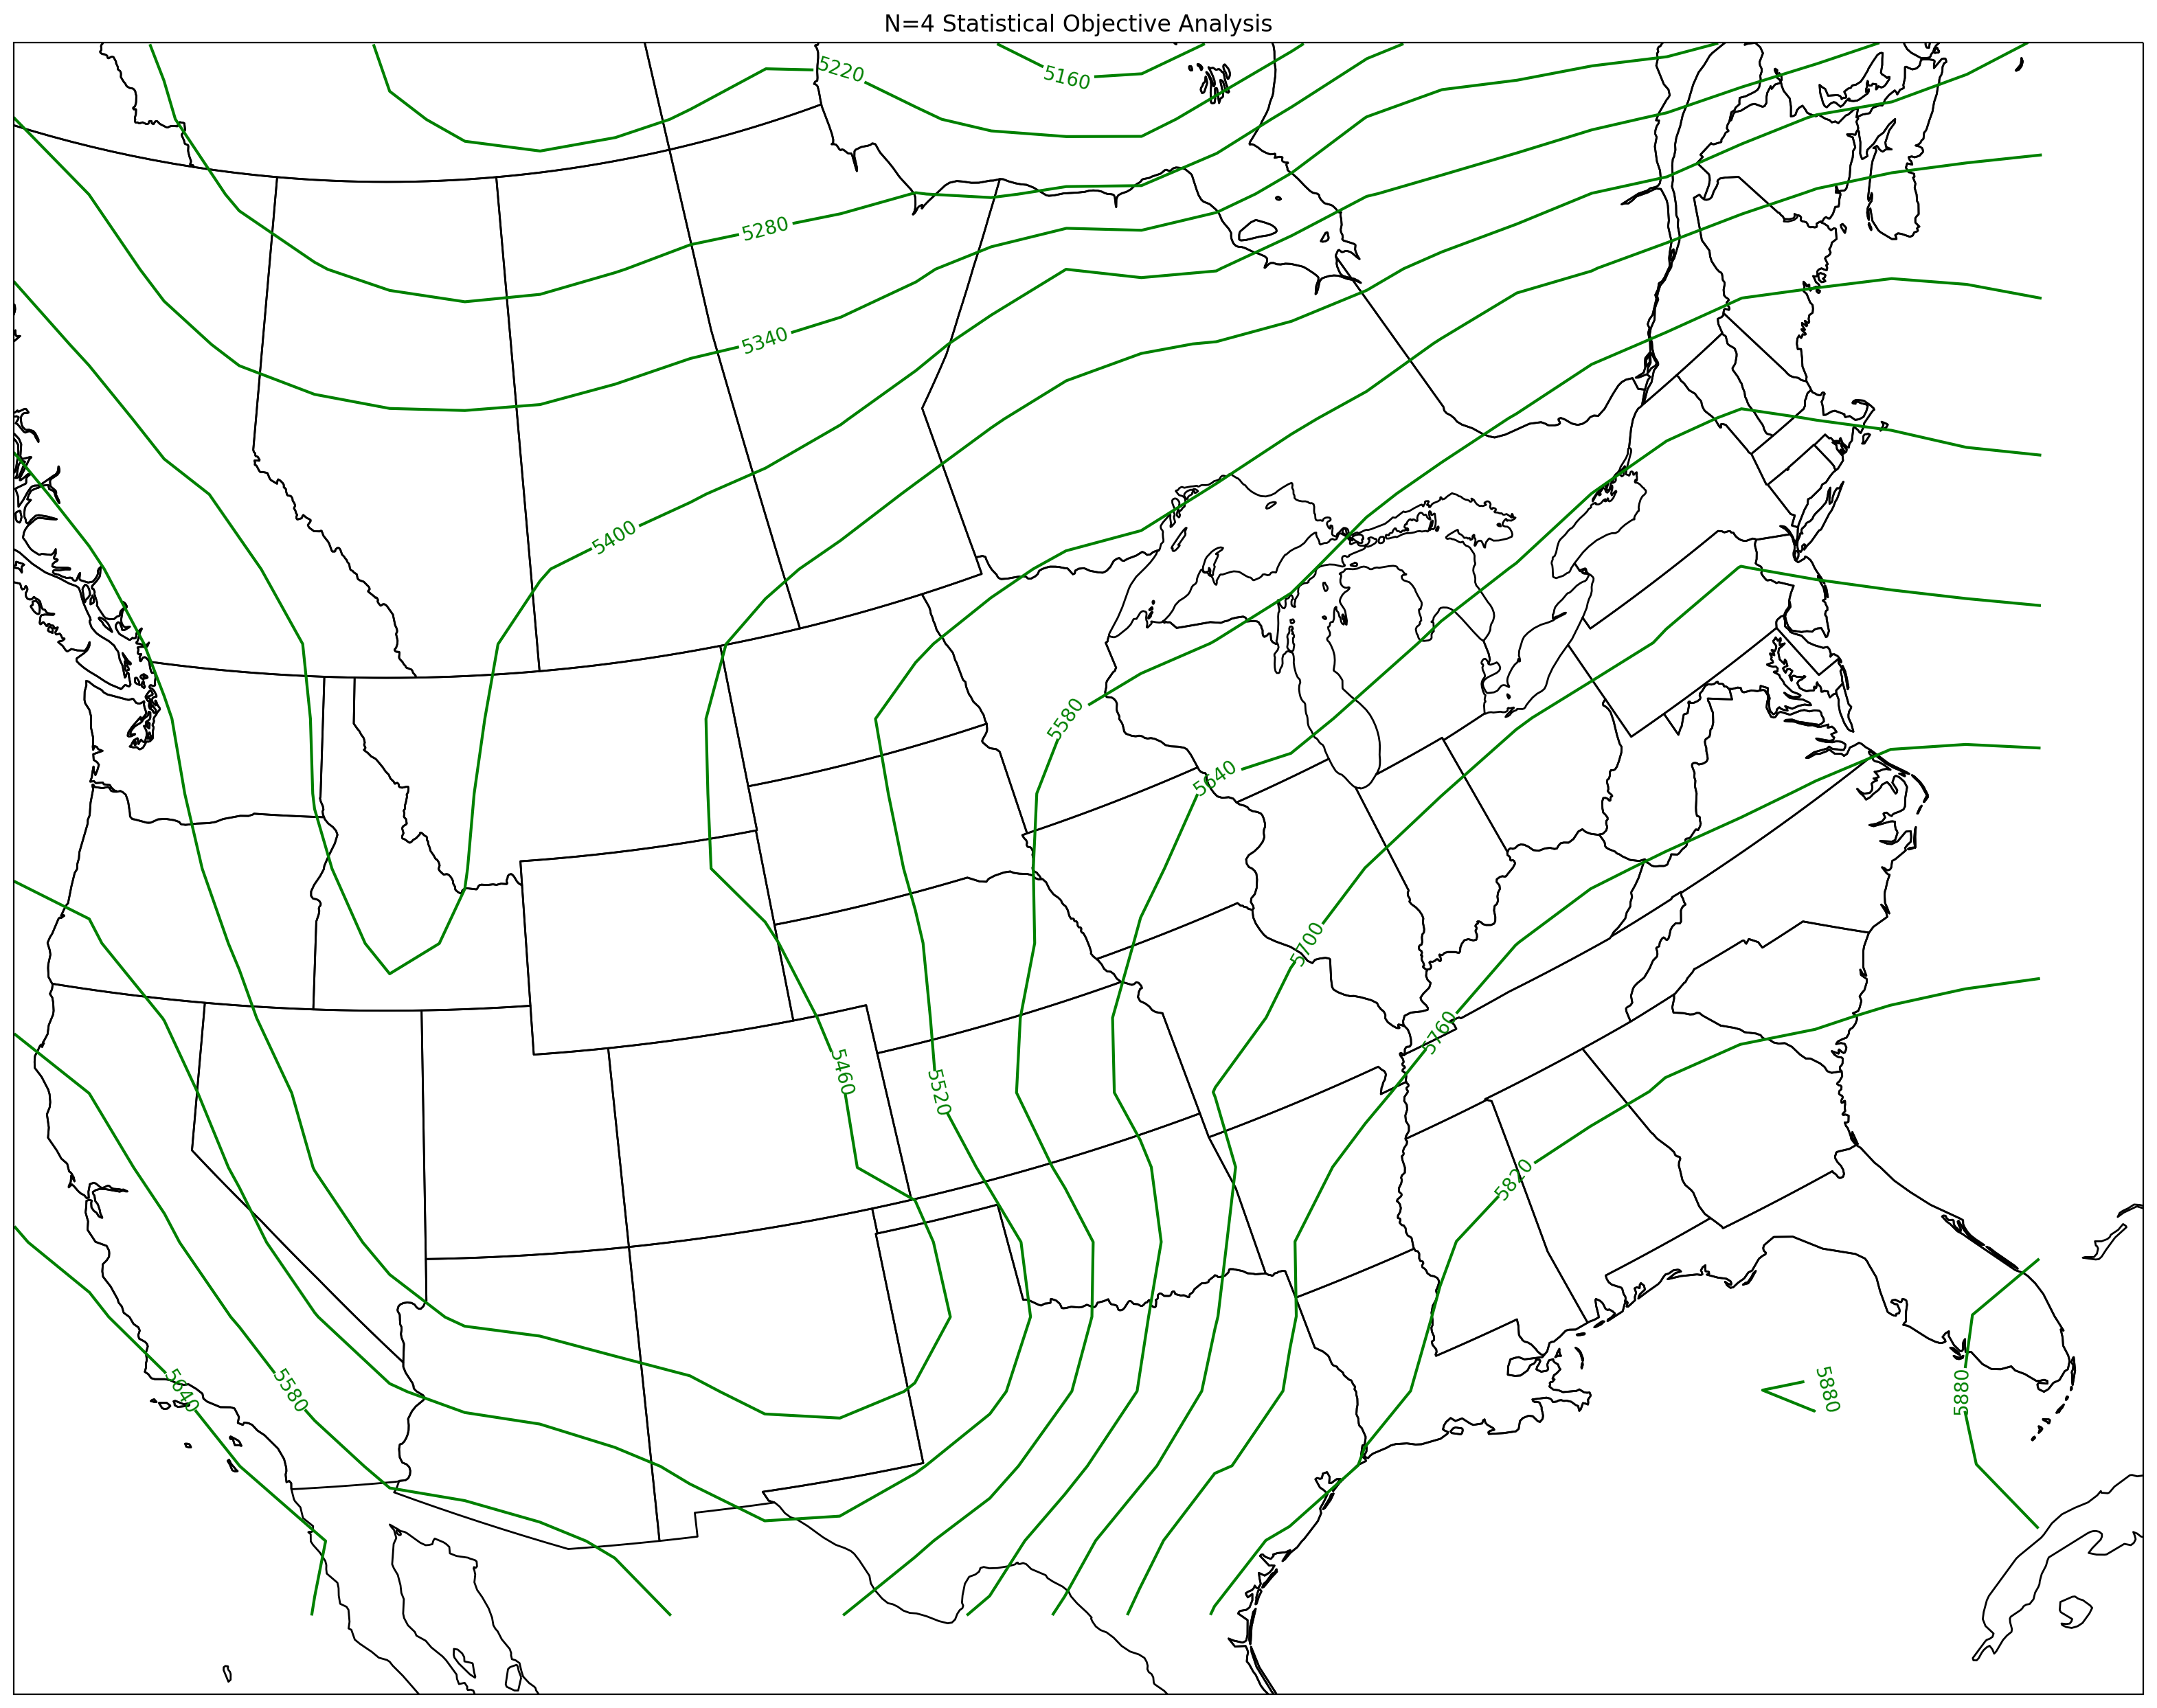

In [116]:
### Make plot for N=4 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_array[:,:,1], colors = 'green', levels = np.arange(0,8000,60), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(0,8000,60))
plt.title('N=4 Statistical Objective Analysis')
plt.savefig('N=4 SOA')
plt.show()

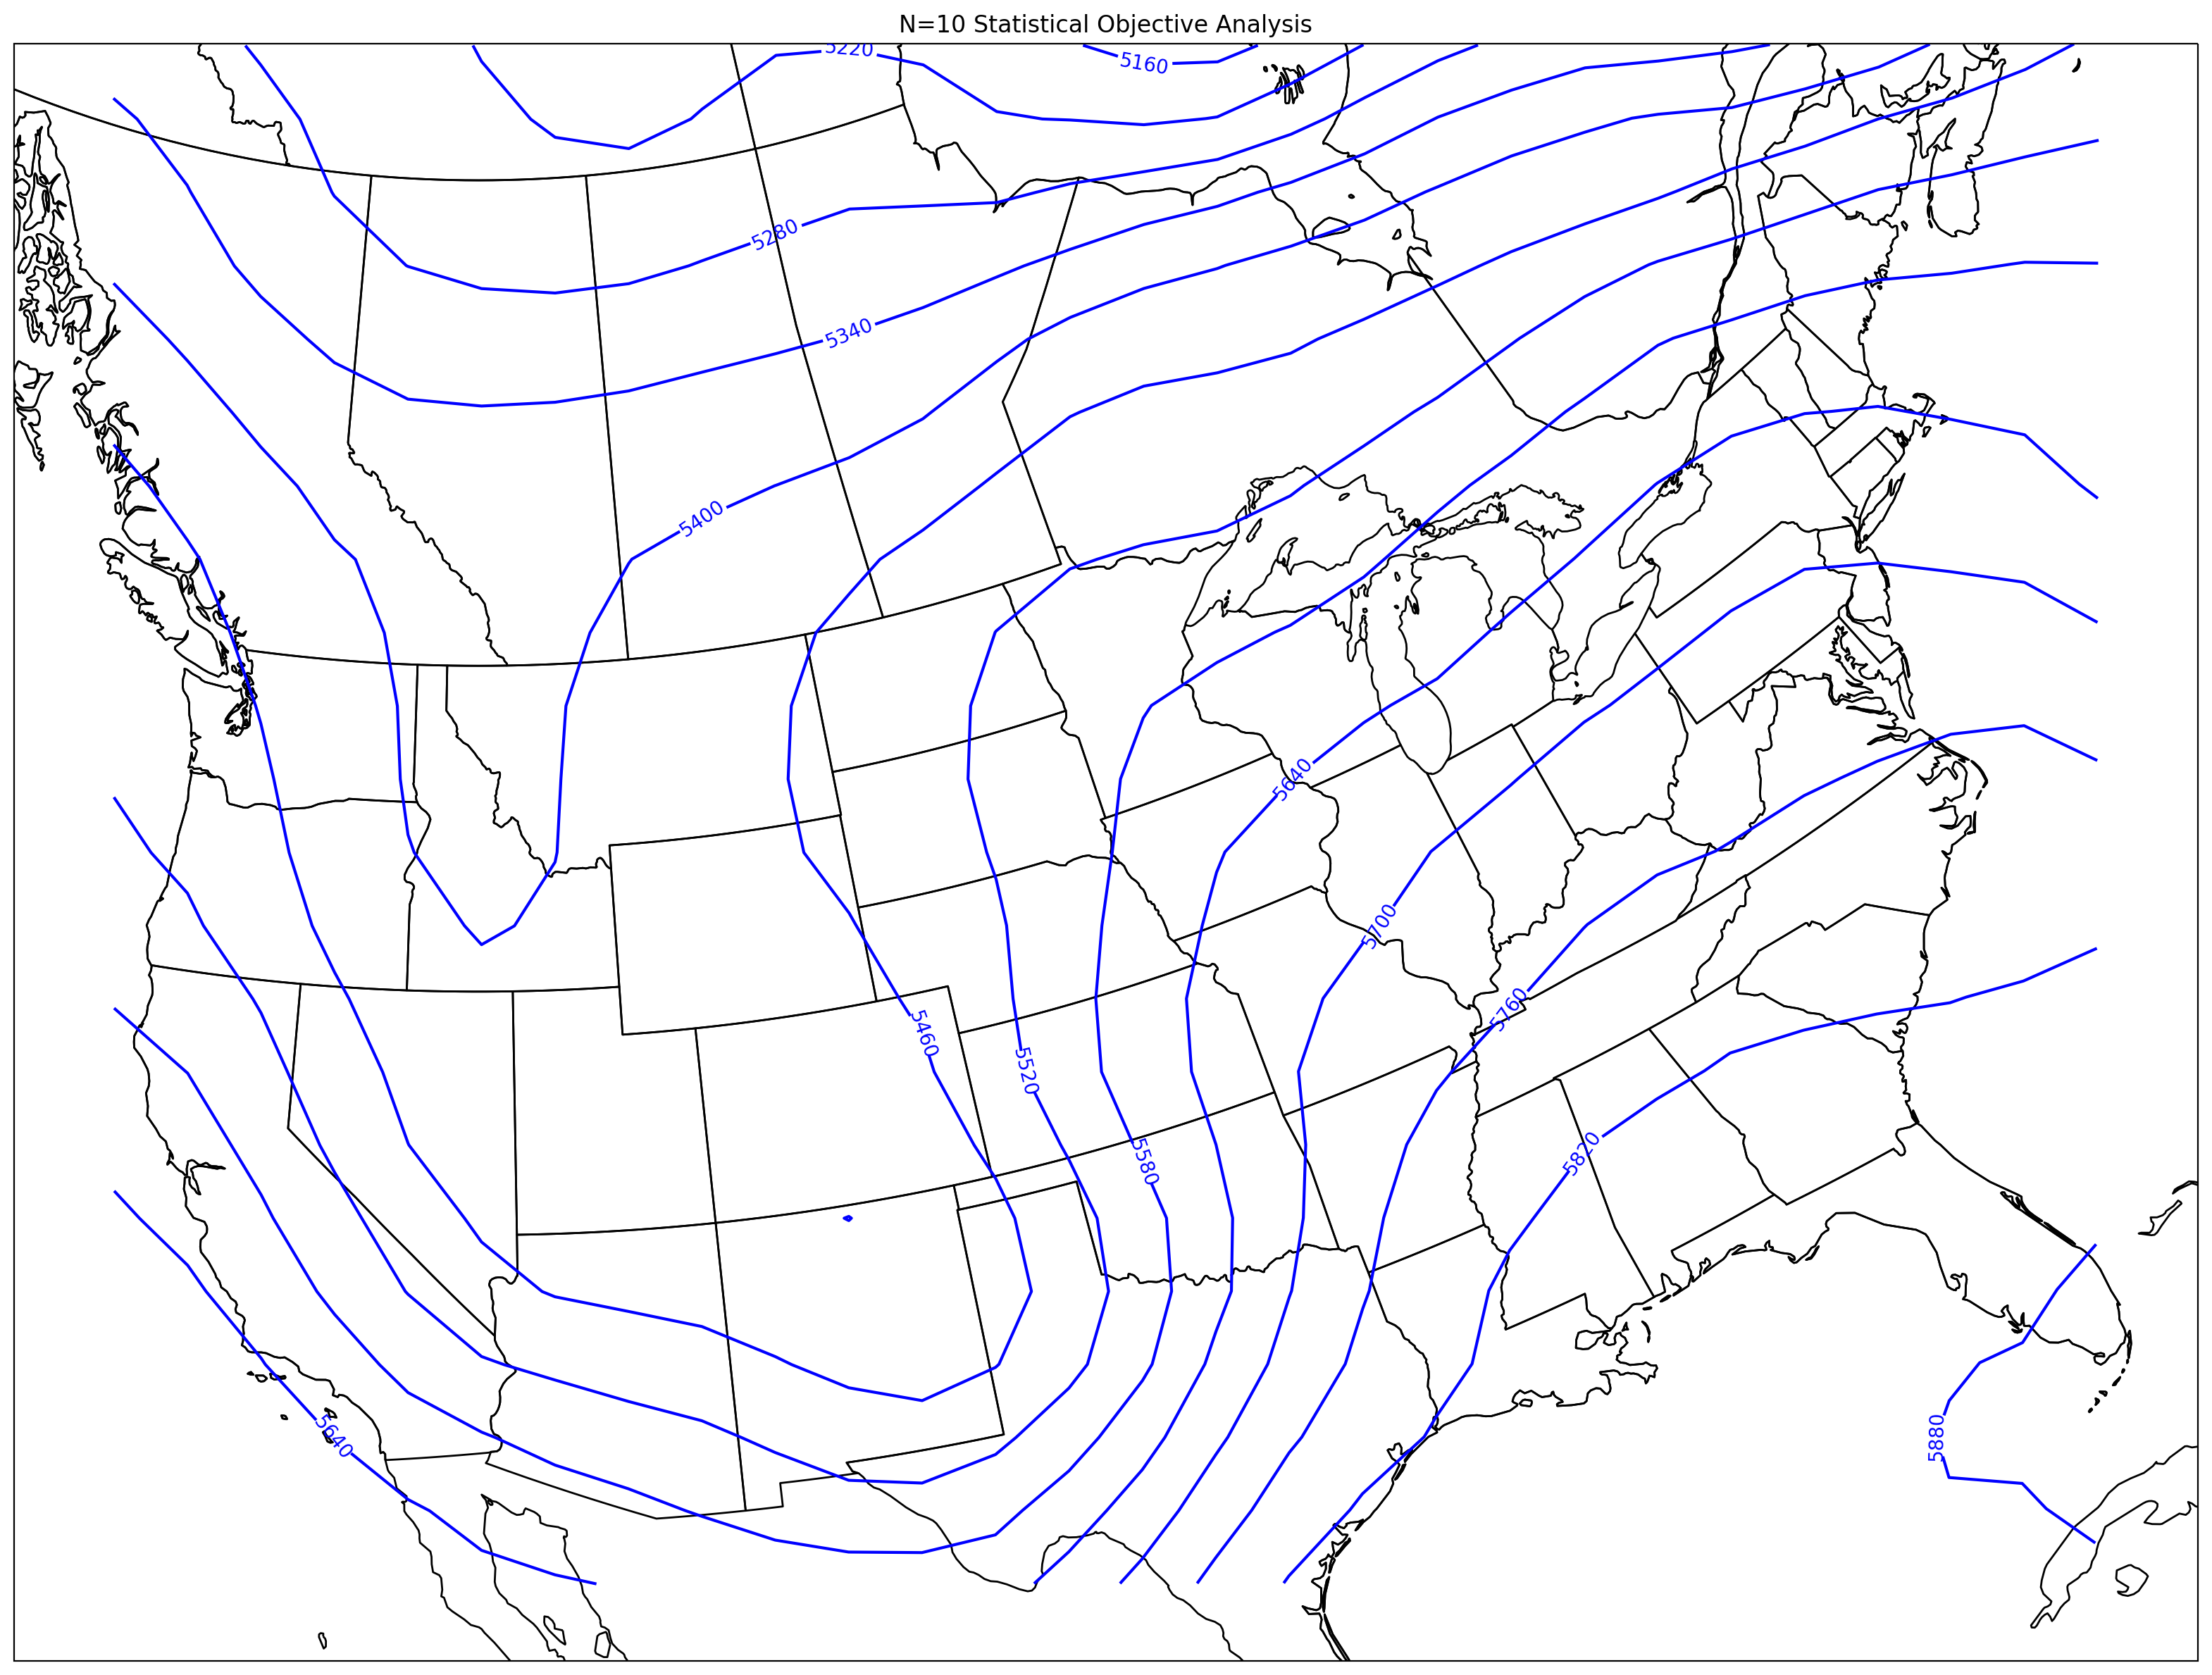

In [117]:
### Make plot for N=10 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_array[:,:,2], colors = 'blue', levels = np.arange(0,8000,60), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(0,8000,60))
plt.title('N=10 Statistical Objective Analysis')
plt.savefig('N=10 SOA')
plt.show()

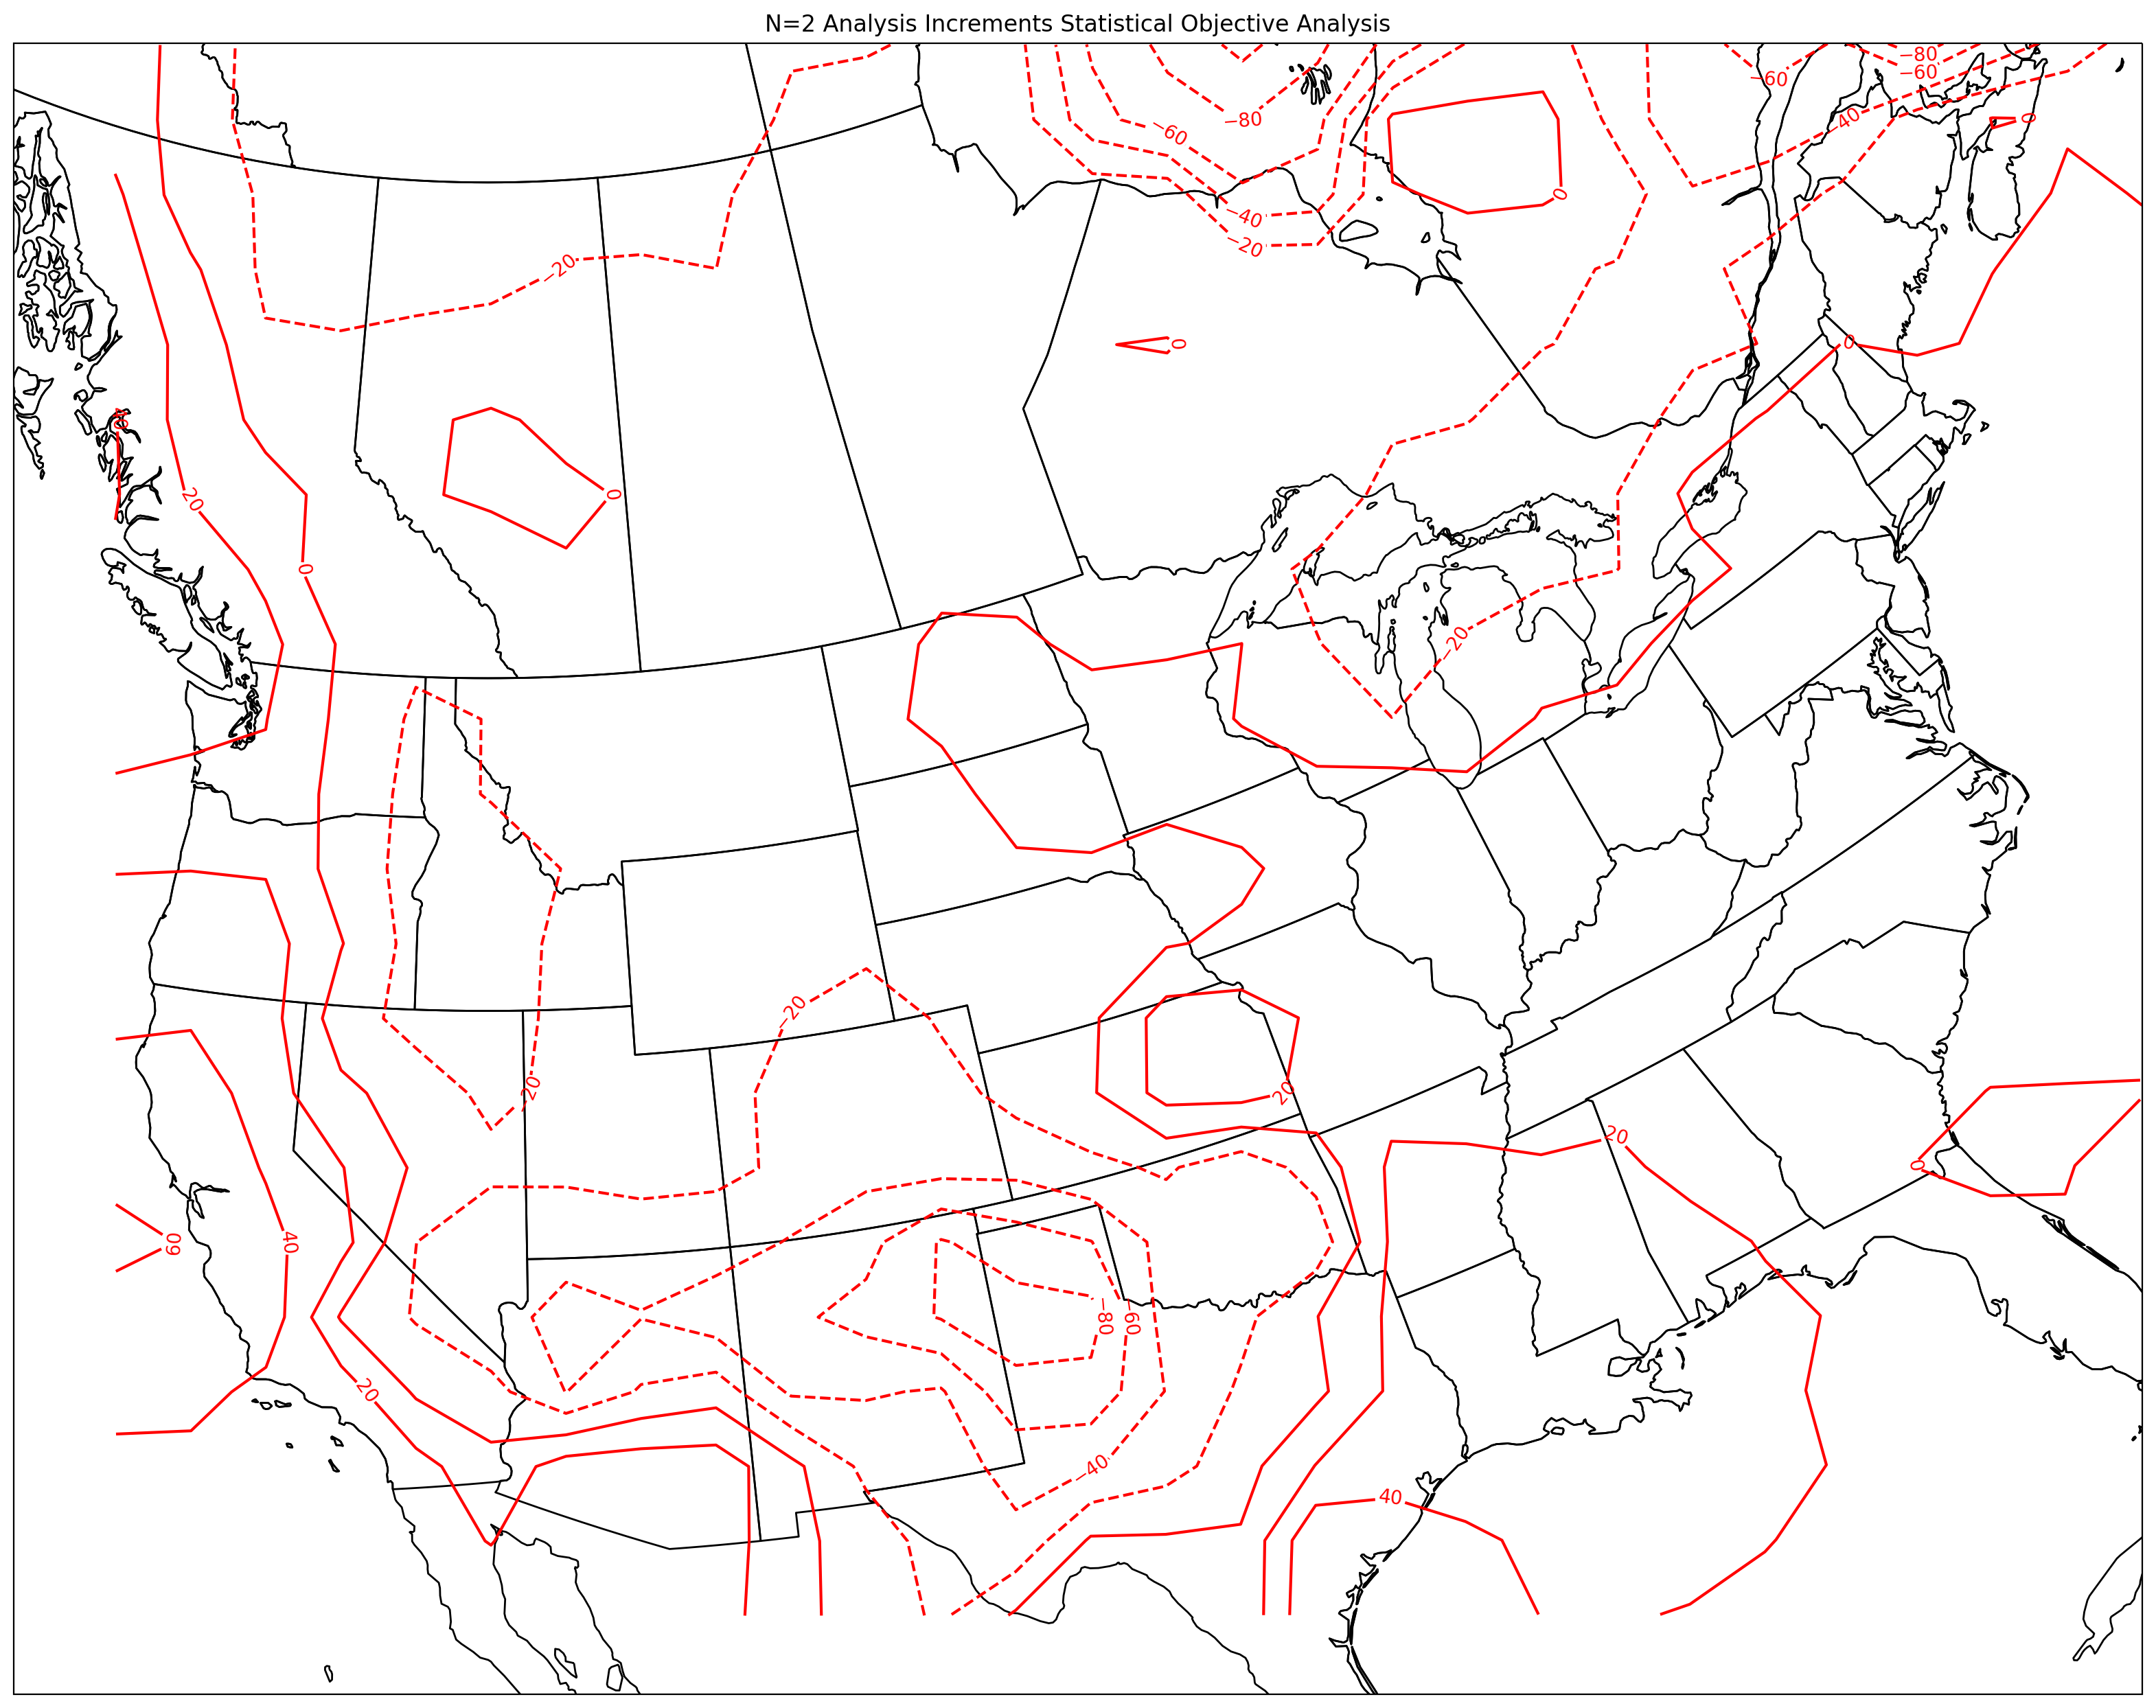

In [120]:
### Make plot for analysis increments N=2 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_increments[:,:,0], colors = 'red', levels = np.arange(-500,500,20), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(-500,500,20))
plt.title('N=2 Analysis Increments Statistical Objective Analysis')
plt.savefig('N=4 Analysis Increments SOA')
plt.show()

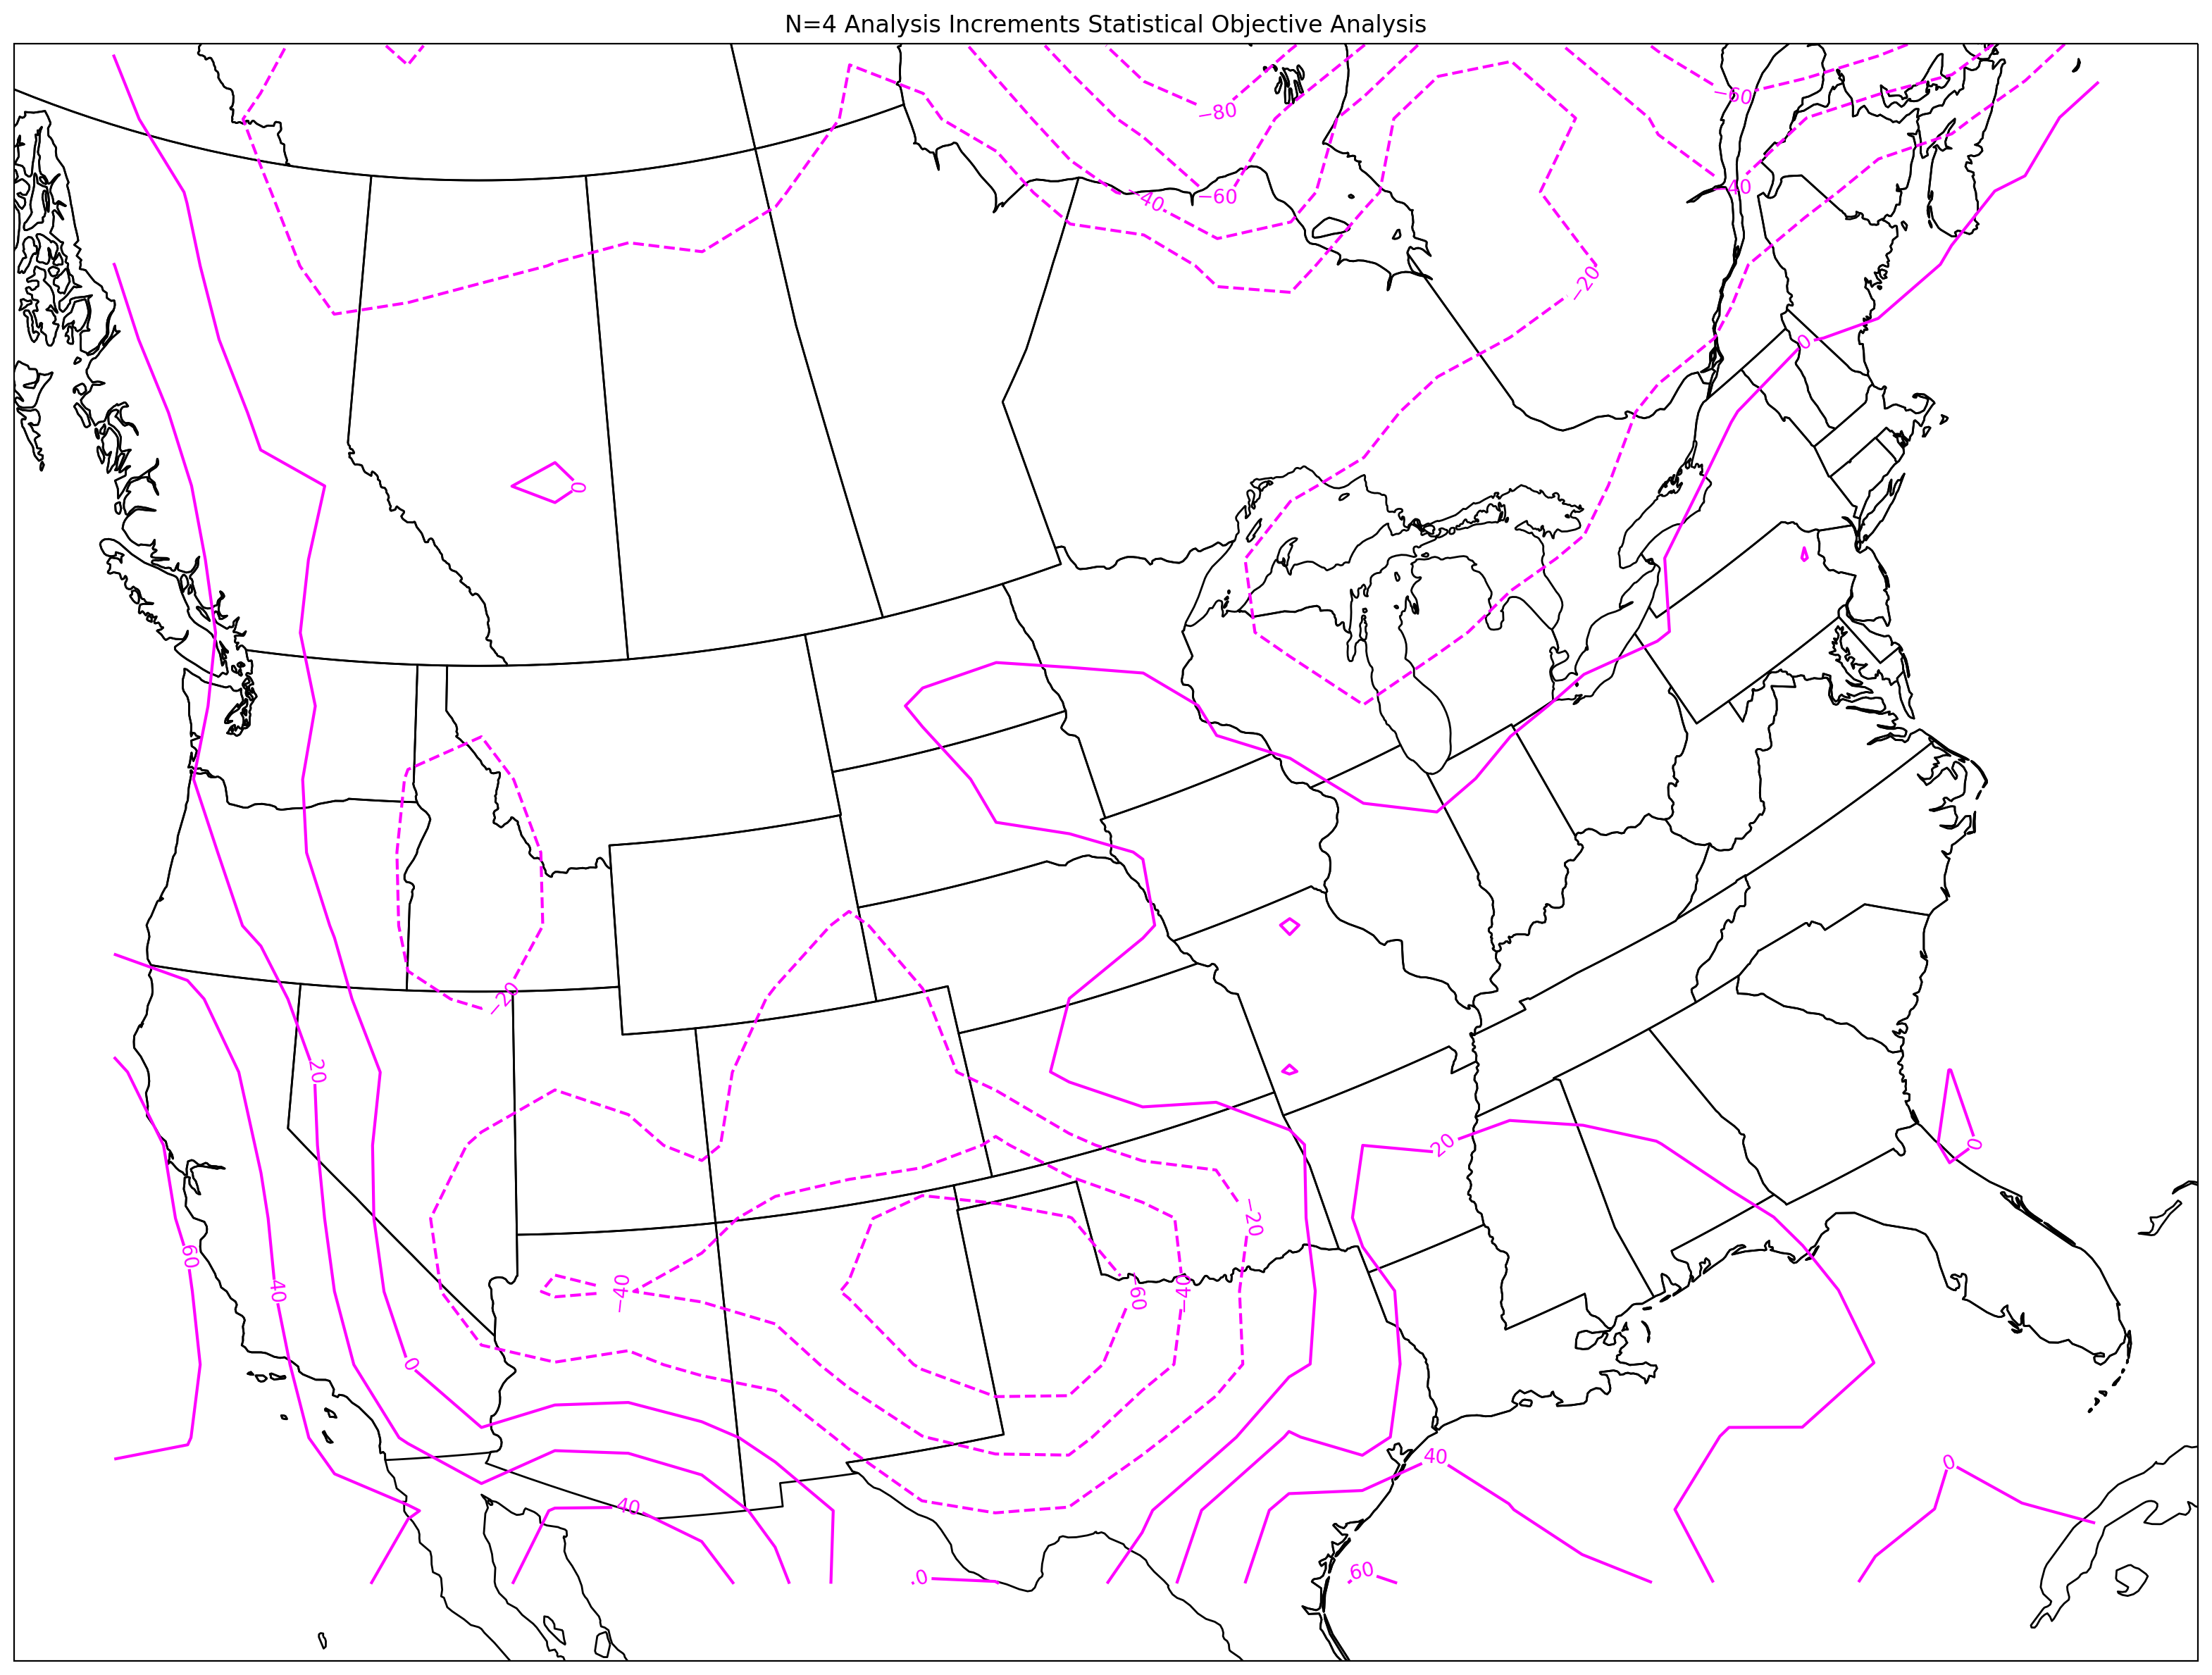

In [122]:
### Make plot for analysis increments N=4 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_increments[:,:,1], colors = 'fuchsia', levels = np.arange(-500,500,20), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(-500,500,20))
plt.title('N=4 Analysis Increments Statistical Objective Analysis')
plt.savefig('N=4 Analysis Increments SOA')
plt.show()

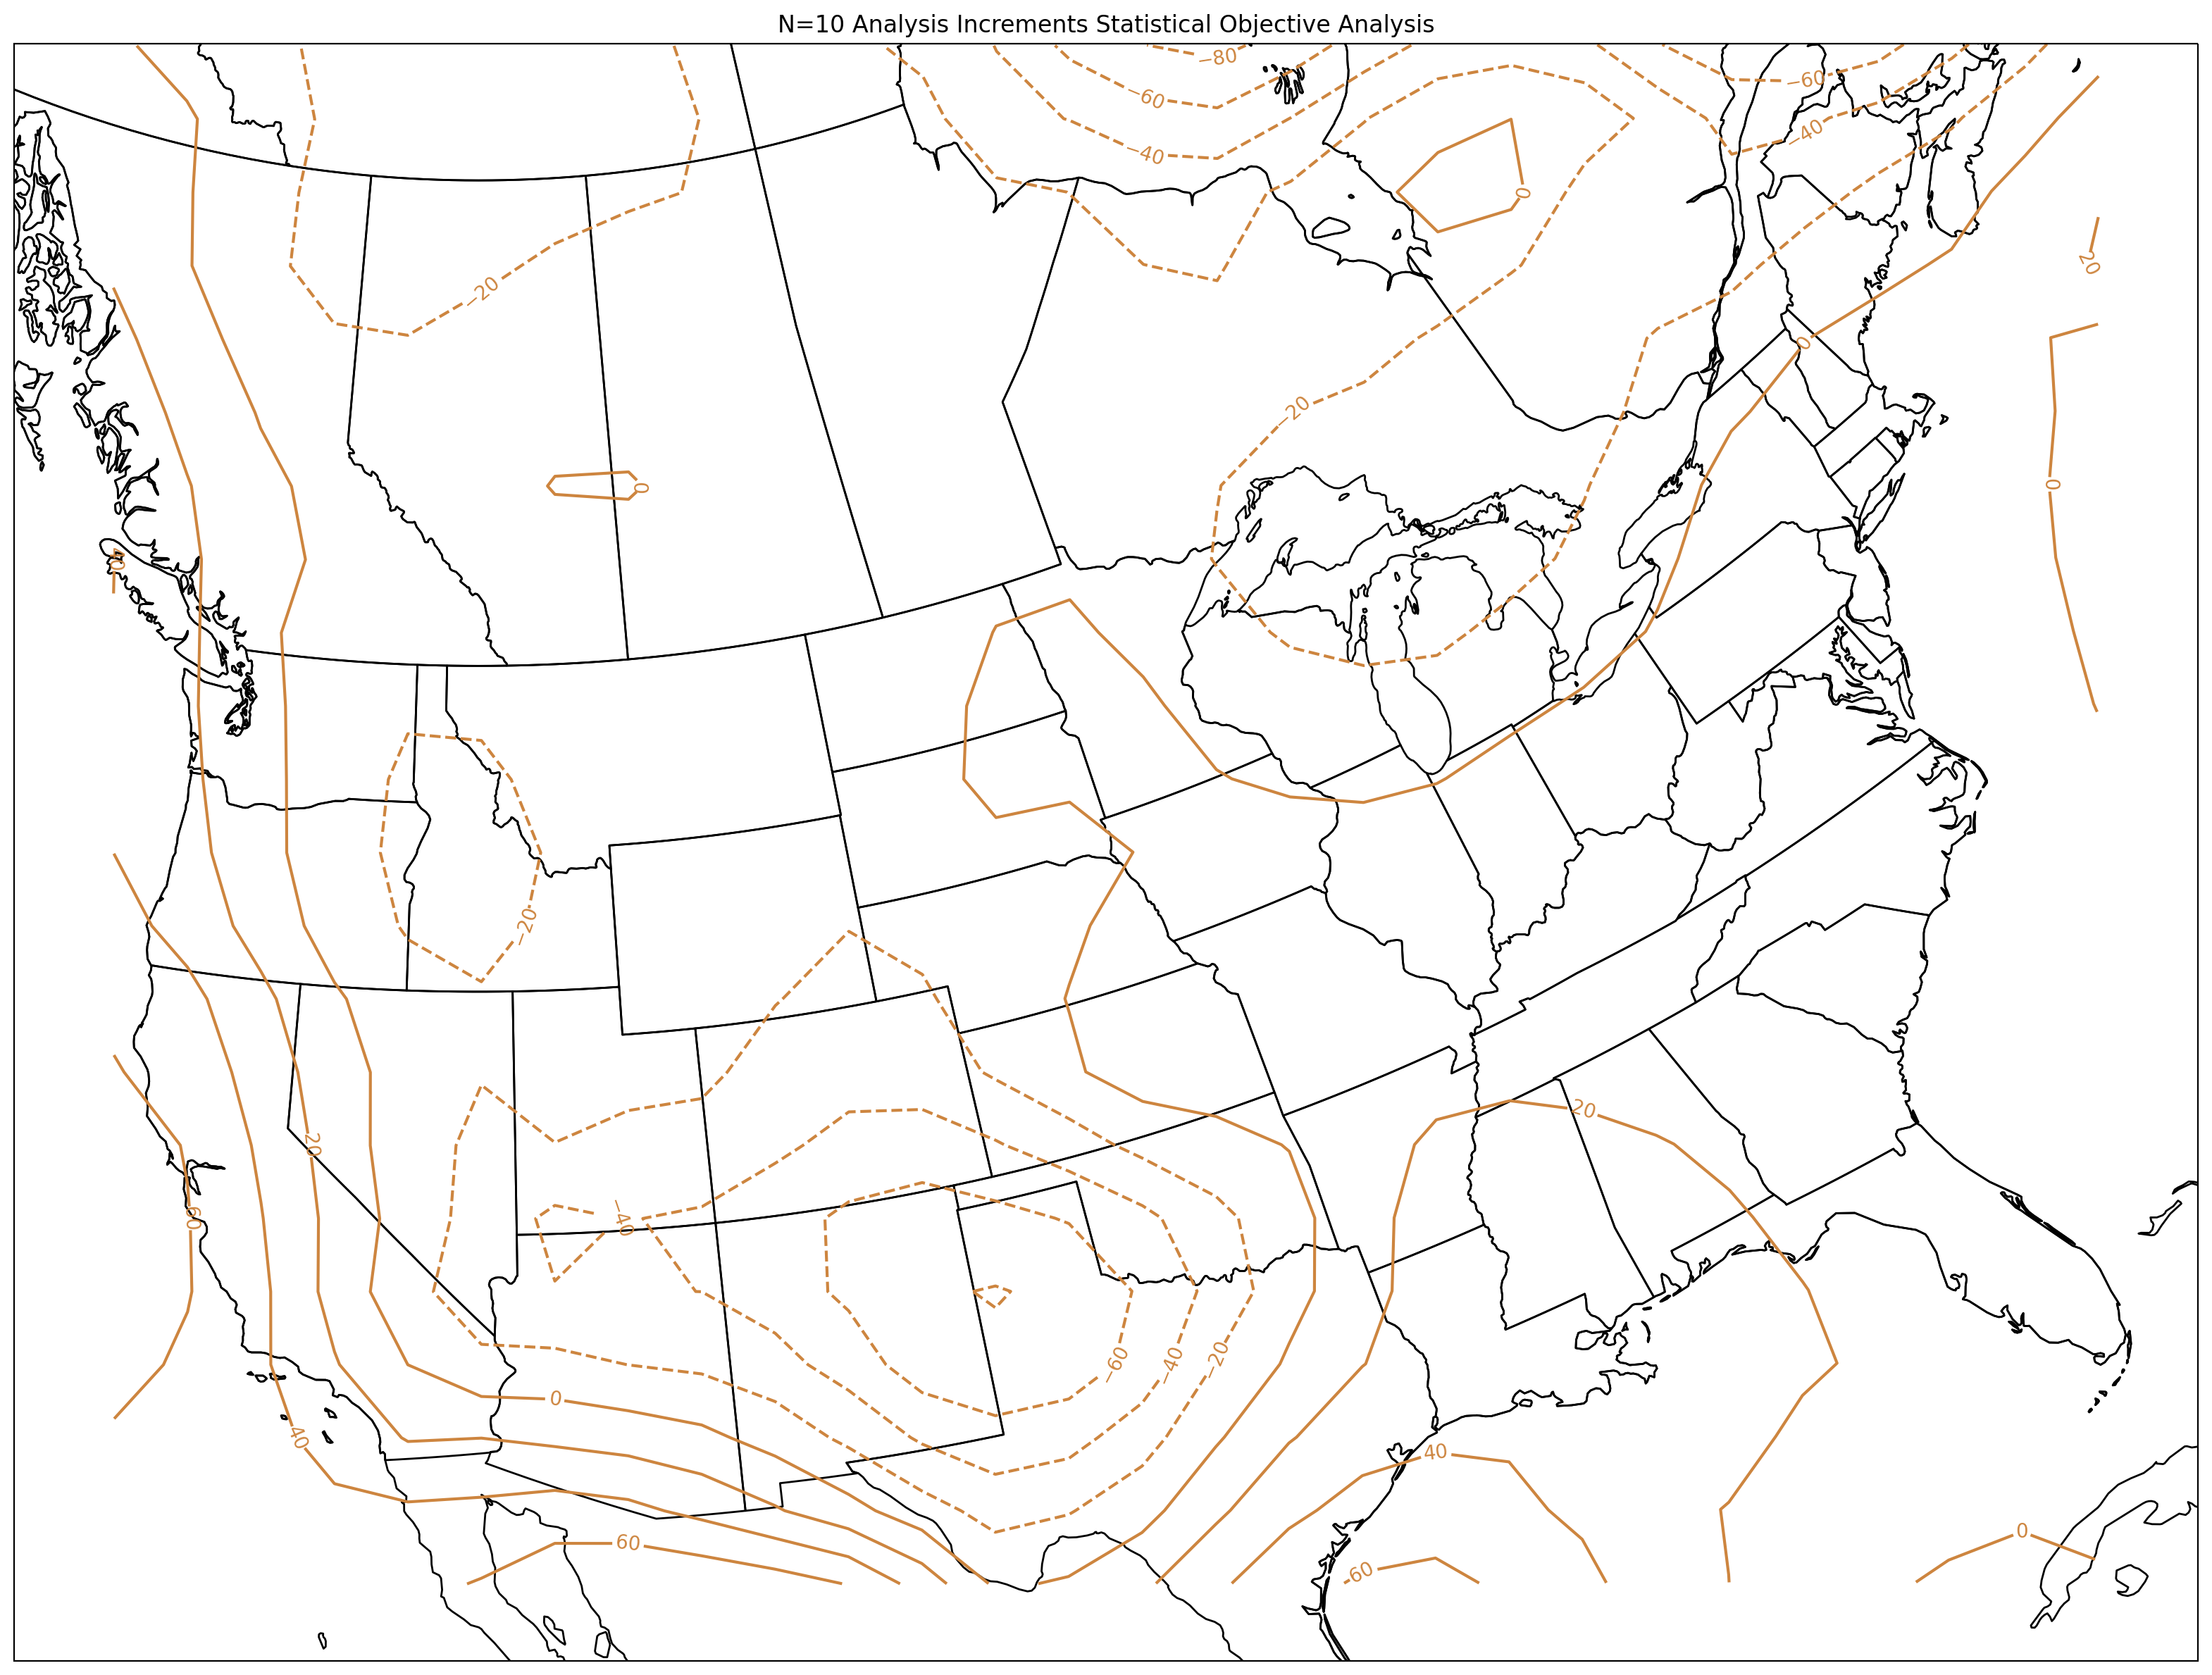

In [125]:
### Make plot for analysis increments N=10 ###
fig = plt.figure(figsize=(20,20), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lon_grid, lat_grid, ana_increments[:,:,2], colors = 'peru', levels = np.arange(-500,500,20), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(-500,500,20))
plt.title('N=10 Analysis Increments Statistical Objective Analysis')
plt.savefig('N=10 Analysis Increments SOA')
plt.show()

In [126]:
#Write out analysis values and analysis increments for N=2 for each point to the file
with open('Nielsen_SOA_N_2.txt', 'w+') as f:
    f.write('grid point, analysis value, analysis increment\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            ana_value = str(ana_array[i,j,0])
            ana_inc = str(ana_increments[i,j,0])
            out_string = grid_point + ',' + ana_value + ',' + ana_inc + '\n'
            f.write(out_string)

In [127]:
#Write out analysis values and analysis increments for N=4 for each point to the file
with open('Nielsen_SOA_N_4.txt', 'w+') as f:
    f.write('grid point, analysis value, analysis increment\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            ana_value = str(ana_array[i,j,1])
            ana_inc = str(ana_increments[i,j,1])
            out_string = grid_point + ',' + ana_value + ',' + ana_inc + '\n'
            f.write(out_string)

In [128]:
#Write out analysis values and analysis increments for N=10 for each point to the file
with open('Nielsen_SOA_N_10.txt', 'w+') as f:
    f.write('grid point, analysis value, analysis increment\n')
    for i in range(len(x_points)):
        for j in range(len(x_points[0])):
            grid_point = str([i,j])
            ana_value = str(ana_array[i,j,2])
            ana_inc = str(ana_increments[i,j,2])
            out_string = grid_point + ',' + ana_value + ',' + ana_inc + '\n'
            f.write(out_string)

In [132]:
#Write out analysis differences for each point to the file
with open('Nielsen_SOA_differences.txt', 'w+') as f:
    f.write('observation point, N, analysis difference\n')
    for n in range(len(n_values)):
        nums_N = n_values[n]
        for i in range(len(hgts_500)):
            observation_point = str(i)
            analysis_diff = str(ana_diff[i,n])
            out_string = observation_point + ',' + str(nums_N) + ',' + analysis_diff + '\n'
            f.write(out_string)

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    
    The general features seen in the contoured analyses are a trough and a ridge. The ridge is located
    over the Eastern United States and the trough is located over the Western United States. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    The main difference in the contoured analyses is that they get smoother as we take more obs that 
    are close to the point we are analyzing. The N=10 analysis is the smoothest of the 3 analyses performed.
    Taking more obs into consideration when performing our analysis caused the smoother analyses.

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
    As we increased the number of points considered for the anaylsis, we smoothed over some of the smaller
    scale features present in the flow. This is not exactly desirable. We don't want really jagged countours
    like N=2, but we don't want to lose the shortwave disturbances in the flow like N=10. If we were looking 
    to anaylze small scale features, N=2 or N=4 would probably be best, but if we wanted to look at the 
    overall flow and only look at the largest scale features, N=10 would be the best bet. 
'''